In [1]:
"""
SEE: https://github.com/sudoswap/lssvm/blob/main/src/LSSVMPair.sol
Events to query for are:
  1. SwapNFTInPair()
    - emitted by LSSVMPair::swapNFTsForToken (sell order)
  2. SwapNFTOutPair()
    - emitted by LSSVMPair::swapTokenForAnyNFTs (buy order)
  3. FeeUpdate()
    - emitted by LSSVMPair::changeFee
  4. DeltaUpdate()
    - emitted by LSSVMPair::changeDelta, ::swapNFTsForToken, ::swapTokenForAnyNFTs

Pool analysis for a given pair contract.

SHOULD replicate https://github.com/sudoswap/pools-analysis but with historical charts for
pool performance.
"""
# switch to sudo-ape wd first for ape project to work properly
import os
from pathlib import Path

if Path(*Path(os.getcwd()).parts[-2:]) == Path('sudo-ape/notebook'):
    os.chdir('..')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import typing as tp

from ape import accounts, chain, Contract, networks, project

In [4]:
networks.parse_network_choice('ethereum:mainnet:alchemy').__enter__()

<alchemy chain_id=1>

In [5]:
start_block = 14645816  # pair factory deployment
start_block

14645816

In [6]:
current_block = chain.blocks[-1].number
current_block

15717821

In [7]:
# TODO: change to whatever pool address you want
# TODO: change to deploy block for pool you want; could get from factory.NewPair events, but being lazy

# 0xmon values
deploy_block = 15181476
pool_addr = "0x5caf332dca4e6c9e69d52f320c21e74845353db0"
pool = project.LSSVMPair.at(pool_addr)

In [8]:
pool

<LSSVMPair 0x5caF332DcA4e6C9E69d52F320c21e74845353db0>

In [9]:
# curve type
curve = Contract(pool.bondingCurve())
curve

<LinearCurve 0x5B6aC51d9B1CeDE0068a1B26533CAce807f883Ee>

In [10]:
# collection
collection = project.ERC721.at(pool.nft())
collection

<ERC721 0x0427743DF720801825a5c82e0582B1E915E0F750>

In [11]:
# utility functions to unfold event arguments into separate columns
def unfold_event_args(key: str, event_args: dict) -> tp.Any:
    return event_args[key]

def unfold(df: pd.DataFrame):
    if df.empty:
        return
    for key in df.iloc[-1]['event_arguments'].keys():
        df[key] = df['event_arguments'].apply(lambda ev: unfold_event_args(key, ev))

In [12]:
# get initial fee, delta, price attributes at pool deploy
price_initial = pool.spotPrice(block_identifier=deploy_block)  # initial spot price in wei
delta_initial = pool.delta(block_identifier=deploy_block)  # initial delta
fee_initial = pool.fee(block_identifier=deploy_block)  # initial fee with 18 decimals
print(f"values at deploy: price = {price_initial}; delta = {delta_initial}; fee = {fee_initial}")

values at deploy: price = 11577669902912621000; delta = 2500000000000000000; fee = 25000000000000000


In [13]:
# query for historical NFT in swap in events
%time query_swaps_in = pool.SwapNFTInPair.query('*', start_block=start_block)
query_swaps_in[:10]

INFO: Cache database has not been initialized
CPU times: user 47 s, sys: 7.62 s, total: 54.6 s
Wall time: 6min 30s


,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index
0,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x195069bfc2a5e1ee78ee3cd8114fdfce8c0d482036d3...,15198846,0xd3b29ce639c43280c2a194b638e07a5e1541824210aa...,57,37
1,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x414ea41198833a399a68c9b66456047bc6dd349330d7...,15208415,0x36dce9b484abf8db83699dabf5d63cbca4b9f68cc7e2...,123,56
2,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x28758b8d0ad21047a93b75089e210e0ca85f652842ef...,15218330,0x10112e7b56853191c7e46d36f0cca7431be567982f5c...,76,59
3,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x0b7981b1331274e198c6e5aee0b0cf568f71c3946e9b...,15232365,0xa5894445a3e40d13ffede5d8de5b0792637dff7db649...,183,126
4,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x75465069ecca43fc7daba4aefd33853c8968aeac7fc4...,15279912,0xe1d0b65d2ef045dde8abe7471b04e3f746091c611f33...,60,24
5,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0xf73cc2c43140b21129064288e080279b447ef73dcd38...,15284547,0x31740c7a4be1ff152694580b68a768ceb246bc4ec9e5...,313,84
6,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x3023d7e712763778f0f49d8723fa18998f3527e3d4b8...,15291179,0xe124608a4134e9e076de26966ee9d522991312f7253e...,104,71
7,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x8f2d12d443584412eb7b5191d2413e4098134c3b418b...,15297928,0x974ce300f99fadf0b083c33deb3253b1513ad2e85316...,157,61
8,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x446121eff4476fa89518cd9c77417f907ef3a783c67a...,15303039,0x278b90842efd2a6df0d9f63b6d50baba7f8c9c8606f0...,18,1
9,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0xd2cd286dea71b61d328b94fd08756d0519dc7e3ed802...,15321994,0xa85b565ce973c82b3ac204d24a003f539c90a2a0c451...,251,141


In [14]:
# query for historical NFT out swap events
%time query_swaps_out = pool.SwapNFTOutPair.query('*', start_block=start_block)
query_swaps_out[:10]

CPU times: user 42.8 s, sys: 6.6 s, total: 49.4 s
Wall time: 6min 9s


,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index
0,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0xe6d9db380c0b7b3d9923ac18e1a920c64a60ef0e2f2e...,15199800,0x420f1997f04b486a8ed114b32337abb0f8722e82ef1f...,82,82
1,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x85212d1b00c2c505bda6b7a56d2b1f2a893646a0d55b...,15203036,0x0e89e72ff162aa1b1ec18cdad70825885d7c0884f425...,236,138
2,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x81073cf223fe0c5be5c4d6c1898033089431f6d1e57c...,15221322,0x56157a3edc0d20332ce0a89d77a1f4d79a80b2eb7847...,71,74
3,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0xed22789a0fb2b93e0cc03f87c8a3d56903c9d5175b90...,15222022,0xefe63b24d1ced117c27382616f8faef81b12560e69bf...,379,203
4,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x01b94ecd67865f46b8f70b02ecac42b33092df846b67...,15231688,0xbb581b19ccba192f1174709e78afc66145999255e78f...,117,64
5,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x400e1b05d002bff37f59d191e544a9580bcf0a74a88b...,15279524,0xd01b0d5c2a04b37c5ac064b569be4fc2d3d010a64ecd...,316,168
6,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x3051550dda227e6d301ab444dd95553dab30b75726da...,15280287,0x112c11e5fbc3b6c835f742a676f5772afb4fd622c010...,154,52
7,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x5c9d27d3ea06332c38e8a6fcae54a171fe92492404f8...,15291055,0x8ad9a6bd6c5dae22abd42fcef1604d7cb5681983c746...,284,138
8,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x6d95f002549235171dedfc3063e9cc51b76bb23a72fd...,15306841,0x60aa9716efbfb913846d871b7181be452273479d7f95...,523,515
9,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x33c9c5b3cb79dd803b74b57acb228bc0033635b64145...,15310405,0x3660dfc5de165ec8af62f1787072ebccf6f060dbe1b1...,130,76


In [15]:
# combine the two queries sorting by (block_number, transaction_index)
query_swaps = pd.concat([query_swaps_in, query_swaps_out]).sort_values(by=['block_number', 'transaction_index'])

In [16]:
query_swaps

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index
0,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x195069bfc2a5e1ee78ee3cd8114fdfce8c0d482036d3...,15198846,0xd3b29ce639c43280c2a194b638e07a5e1541824210aa...,57,37
0,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0xe6d9db380c0b7b3d9923ac18e1a920c64a60ef0e2f2e...,15199800,0x420f1997f04b486a8ed114b32337abb0f8722e82ef1f...,82,82
1,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x85212d1b00c2c505bda6b7a56d2b1f2a893646a0d55b...,15203036,0x0e89e72ff162aa1b1ec18cdad70825885d7c0884f425...,236,138
1,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x414ea41198833a399a68c9b66456047bc6dd349330d7...,15208415,0x36dce9b484abf8db83699dabf5d63cbca4b9f68cc7e2...,123,56
2,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x28758b8d0ad21047a93b75089e210e0ca85f652842ef...,15218330,0x10112e7b56853191c7e46d36f0cca7431be567982f5c...,76,59
...,...,...,...,...,...,...,...,...
36,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x0f0c92c52a66419cf127e6d95465200306c53ba0f614...,15583837,0xac80c3a0f4b64fbcb0512cf4bcbfc67f77cb37a6bd36...,85,37
32,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x3343670d15a90410dd5f689d9e6349e2a4343b7472e0...,15622000,0x76e15f58bc7e39a5e164277fa0b2bc2c6648f510adf7...,74,47
37,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0xb11f71335fc38495ae8e9a3dac52bf8cf452f7b02c74...,15630253,0x9f61426c708fcd4622f26fd23b607c65a2cf08d3c4a2...,20,26
33,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0xa1759dc5b910d93a3464b9814e8010bddd25dafe66d7...,15641940,0xf85ed36d9edc63b7dc156d4a33256e254f8e4b02498a...,159,100


In [17]:
# query transfer events for collection
%time query_transfers = collection.Transfer.query('*', start_block=start_block)
query_transfers[:10]

CPU times: user 41.3 s, sys: 6.44 s, total: 47.8 s
Wall time: 6min 9s


,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index
0,Transfer,0x0427743DF720801825a5c82e0582B1E915E0F750,{'from': '0xF3dca43787d77f846974BE7d75BAeE8AaB...,0xffe959b85f7c31ea40c9e81c7211018fba4b65173e77...,14649722,0x404434ad5238096cbb5354fd7e4f26838256af2d3d87...,113,110
1,Transfer,0x0427743DF720801825a5c82e0582B1E915E0F750,{'from': '0x75d4bdBf6593ed463e9625694272a0FF9a...,0xff03f1a4956f878f1bd42a6dfa2ec18165822cde3d15...,14652223,0x877d4993fe635aaaea71fa3c8bb8c705d67f86559c3e...,141,108
2,Transfer,0x0427743DF720801825a5c82e0582B1E915E0F750,{'from': '0x0636a6Bd07dDBEA28a3cc63353ea725e8c...,0x2d52cdf7294e2abf00ba2c9aeb124f1119d376ad5490...,14652258,0x45bc8a840e7b5353c8967fc6152c279e1ca74df4ec02...,13,7
3,Transfer,0x0427743DF720801825a5c82e0582B1E915E0F750,{'from': '0x008f4C31734052152AddA6afDaD6955379...,0x0398cfe92a9de73c6d6adf566e5af8f69b20ddc5725b...,14652290,0xd40960785cb305acb95b58dc760157855d0811f1195f...,109,45
4,Transfer,0x0427743DF720801825a5c82e0582B1E915E0F750,{'from': '0xbB0f753321e2B5FD29Bd1d14b532f5B549...,0xe3920493fcb9618cc94008490c030255ae9aa9fd1e45...,14671799,0x0d590ad40f1cc782d2703f6e0b62cd6acaa13dceeb98...,231,91
5,Transfer,0x0427743DF720801825a5c82e0582B1E915E0F750,{'from': '0xd48D8cef2F1A7b29BAFb5E17e8B88bfEBa...,0xbeb2daa3907185013eceb28a72dffc87815a057d209a...,14694998,0x38120ee9a8a1b57e09461467ec6ea7903b6a12a400be...,373,297
6,Transfer,0x0427743DF720801825a5c82e0582B1E915E0F750,{'from': '0x83C8F28c26bF6aaca652Df1DbBE0e1b56F...,0xbeb2daa3907185013eceb28a72dffc87815a057d209a...,14694998,0x38120ee9a8a1b57e09461467ec6ea7903b6a12a400be...,376,297
7,Transfer,0x0427743DF720801825a5c82e0582B1E915E0F750,{'from': '0xCd723Fa1BF4D1258d5d6C9d5149e85acfD...,0x37de4c4c8c523ec6633f5d1293c96ed142894a65c6fc...,14713238,0xc80600afee6d241acc39300c502b30d294a12db5eeef...,295,83
8,Transfer,0x0427743DF720801825a5c82e0582B1E915E0F750,{'from': '0x80c939F8A66C59B37330f93f1002541fD4...,0x45767aa315dc2f1f9c215fb1fee239136e7e23f14795...,14747031,0x556aa6640702bd8a0b8a40d54138d5e3aadc9f3970ea...,199,86
9,Transfer,0x0427743DF720801825a5c82e0582B1E915E0F750,{'from': '0x6327343B3a12Fbd25488Da0e82Bd4512aD...,0x1cad6649f4c3c17011cbd033455d7b7ea0d66786e503...,14748679,0xc20d89ae4f3e801415b6417590c7a6f9c996e585fdbc...,195,128


In [18]:
# unfold event args
unfold(query_transfers)

In [19]:
# filter collection transfer events based on swap tx hashes
query_transfers_for_swaps = query_transfers[query_transfers['transaction_hash'].isin(query_swaps['transaction_hash'])].sort_values(by=['block_number', 'log_index'])
query_transfers_for_swaps = query_transfers_for_swaps[(query_transfers_for_swaps['from'] == pool.address) | (query_transfers_for_swaps['to'] == pool.address)]
query_transfers_for_swaps

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,from,to,id
67,Transfer,0x0427743DF720801825a5c82e0582B1E915E0F750,{'from': '0x78D0bAC4E33A047224c5056Cb9891D2816...,0x195069bfc2a5e1ee78ee3cd8114fdfce8c0d482036d3...,15198846,0xd3b29ce639c43280c2a194b638e07a5e1541824210aa...,56,37,0x78D0bAC4E33A047224c5056Cb9891D28168F67c4,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,66
68,Transfer,0x0427743DF720801825a5c82e0582B1E915E0F750,{'from': '0x5caF332DcA4e6C9E69d52F320c21e74845...,0xe6d9db380c0b7b3d9923ac18e1a920c64a60ef0e2f2e...,15199800,0x420f1997f04b486a8ed114b32337abb0f8722e82ef1f...,81,82,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,0xda3845B44736b57E05Ee80fC011A52a9c777423A,267
69,Transfer,0x0427743DF720801825a5c82e0582B1E915E0F750,{'from': '0x5caF332DcA4e6C9E69d52F320c21e74845...,0x85212d1b00c2c505bda6b7a56d2b1f2a893646a0d55b...,15203036,0x0e89e72ff162aa1b1ec18cdad70825885d7c0884f425...,235,138,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,0x85B44a83bCa937E844Bdc290284Ef6b11BC015ba,128
71,Transfer,0x0427743DF720801825a5c82e0582B1E915E0F750,{'from': '0x883F4BF1Cd53692Bb602BFb580d4B15045...,0x414ea41198833a399a68c9b66456047bc6dd349330d7...,15208415,0x36dce9b484abf8db83699dabf5d63cbca4b9f68cc7e2...,122,56,0x883F4BF1Cd53692Bb602BFb580d4B1504539dFb8,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,323
72,Transfer,0x0427743DF720801825a5c82e0582B1E915E0F750,{'from': '0x7A69a8399740fcB54a182957181a5FCA67...,0x28758b8d0ad21047a93b75089e210e0ca85f652842ef...,15218330,0x10112e7b56853191c7e46d36f0cca7431be567982f5c...,75,59,0x7A69a8399740fcB54a182957181a5FCA675e1eF5,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,22
...,...,...,...,...,...,...,...,...,...,...,...
292,Transfer,0x0427743DF720801825a5c82e0582B1E915E0F750,{'from': '0x6291bD1Ecb88D5C8f6702D6Faa91661e2C...,0x0f0c92c52a66419cf127e6d95465200306c53ba0f614...,15583837,0xac80c3a0f4b64fbcb0512cf4bcbfc67f77cb37a6bd36...,84,37,0x6291bD1Ecb88D5C8f6702D6Faa91661e2C0a9e7E,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,316
293,Transfer,0x0427743DF720801825a5c82e0582B1E915E0F750,{'from': '0x5caF332DcA4e6C9E69d52F320c21e74845...,0x3343670d15a90410dd5f689d9e6349e2a4343b7472e0...,15622000,0x76e15f58bc7e39a5e164277fa0b2bc2c6648f510adf7...,73,47,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,0x14df40586e0F2Ca5CA222DB0dAc8Df2f4C5b1AAb,189
295,Transfer,0x0427743DF720801825a5c82e0582B1E915E0F750,{'from': '0x15D3FfAc9B7D5dBbEE095910Db63800402...,0xb11f71335fc38495ae8e9a3dac52bf8cf452f7b02c74...,15630253,0x9f61426c708fcd4622f26fd23b607c65a2cf08d3c4a2...,19,26,0x15D3FfAc9B7D5dBbEE095910Db6380040222b99f,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,110
296,Transfer,0x0427743DF720801825a5c82e0582B1E915E0F750,{'from': '0x5caF332DcA4e6C9E69d52F320c21e74845...,0xa1759dc5b910d93a3464b9814e8010bddd25dafe66d7...,15641940,0xf85ed36d9edc63b7dc156d4a33256e254f8e4b02498a...,158,100,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,0x33569c101562e1fAF5b24581057E5cEE4c8288D7,110


In [20]:
# back to attributes:
# get all fee updates for the pool
%time query_fee_updates = pool.FeeUpdate.query('*', start_block=start_block)

CPU times: user 38.7 s, sys: 6.04 s, total: 44.8 s
Wall time: 6min 11s


In [21]:
if not query_fee_updates.empty:
    unfold(query_fee_updates)

query_fee_updates

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index


In [22]:
# get all delta updates for the pool
%time query_delta_updates = pool.DeltaUpdate.query('*', start_block=start_block)

CPU times: user 38.3 s, sys: 5.87 s, total: 44.2 s
Wall time: 5min 55s


In [23]:
if not query_delta_updates.empty:
    unfold(query_delta_updates)

In [24]:
query_delta_updates

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index


In [25]:
# get all the spot price updates for the pool
%time query_price_updates = pool.SpotPriceUpdate.query('*', start_block=start_block)
query_price_updates[:10]

CPU times: user 38 s, sys: 5.94 s, total: 43.9 s
Wall time: 6min 17s


,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index
0,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9077669902912621000},0x195069bfc2a5e1ee78ee3cd8114fdfce8c0d482036d3...,15198846,0xd3b29ce639c43280c2a194b638e07a5e1541824210aa...,54,37
1,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 11577669902912621000},0xe6d9db380c0b7b3d9923ac18e1a920c64a60ef0e2f2e...,15199800,0x420f1997f04b486a8ed114b32337abb0f8722e82ef1f...,79,82
2,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 14077669902912621000},0x85212d1b00c2c505bda6b7a56d2b1f2a893646a0d55b...,15203036,0x0e89e72ff162aa1b1ec18cdad70825885d7c0884f425...,233,138
3,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 11577669902912621000},0x414ea41198833a399a68c9b66456047bc6dd349330d7...,15208415,0x36dce9b484abf8db83699dabf5d63cbca4b9f68cc7e2...,120,56
4,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9077669902912621000},0x28758b8d0ad21047a93b75089e210e0ca85f652842ef...,15218330,0x10112e7b56853191c7e46d36f0cca7431be567982f5c...,73,59
5,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 11577669902912621000},0x81073cf223fe0c5be5c4d6c1898033089431f6d1e57c...,15221322,0x56157a3edc0d20332ce0a89d77a1f4d79a80b2eb7847...,68,74
6,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 14077669902912621000},0xed22789a0fb2b93e0cc03f87c8a3d56903c9d5175b90...,15222022,0xefe63b24d1ced117c27382616f8faef81b12560e69bf...,376,203
7,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 16577669902912621000},0x01b94ecd67865f46b8f70b02ecac42b33092df846b67...,15231688,0xbb581b19ccba192f1174709e78afc66145999255e78f...,114,64
8,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 14077669902912621000},0x0b7981b1331274e198c6e5aee0b0cf568f71c3946e9b...,15232365,0xa5894445a3e40d13ffede5d8de5b0792637dff7db649...,180,126
9,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 16577669902912621000},0x400e1b05d002bff37f59d191e544a9580bcf0a74a88b...,15279524,0xd01b0d5c2a04b37c5ac064b569be4fc2d3d010a64ecd...,313,168


In [26]:
# use all the info to build a picture of pool performance over time
unfold(query_price_updates)

In [27]:
# sort, filter and add in initial price data
query_price_updates_filtered = query_price_updates.sort_values(by=['block_number', 'log_index']).filter(['block_number', 'log_index', 'transaction_hash', 'newSpotPrice'])
data_initial = {'block_number': [deploy_block], 'log_index': [0], 'newSpotPrice': [price_initial]}
query_prices = pd.concat([pd.DataFrame(data=data_initial), query_price_updates_filtered])
query_prices

,block_number,log_index,newSpotPrice,transaction_hash
0,15181476,0,11577669902912621000,NaN
0,15198846,54,9077669902912621000,0x195069bfc2a5e1ee78ee3cd8114fdfce8c0d482036d3...
1,15199800,79,11577669902912621000,0xe6d9db380c0b7b3d9923ac18e1a920c64a60ef0e2f2e...
2,15203036,233,14077669902912621000,0x85212d1b00c2c505bda6b7a56d2b1f2a893646a0d55b...
3,15208415,120,11577669902912621000,0x414ea41198833a399a68c9b66456047bc6dd349330d7...
...,...,...,...,...
69,15583837,82,7330097087378640000,0x0f0c92c52a66419cf127e6d95465200306c53ba0f614...
70,15622000,71,9830097087378640000,0x3343670d15a90410dd5f689d9e6349e2a4343b7472e0...
71,15630253,17,7330097087378640000,0xb11f71335fc38495ae8e9a3dac52bf8cf452f7b02c74...
72,15641940,156,9830097087378640000,0xa1759dc5b910d93a3464b9814e8010bddd25dafe66d7...


In [28]:
# norm prices to ETH terms
query_prices_normed = query_prices.copy()
query_prices_normed['newSpotPrice'] /= 1e18

In [29]:
# determine prices each NFT was bought or sold for by cross ref query swaps with query prices
# add in as a column to query transfers

# NOTE: SpotPriceUpdate emitted BEFORE nft Transfer events: https://github.com/fmrmf/sudo-ape/blob/main/contracts/lssvm/LSSVMPair.sol#L216
# NOTE: so can use the SpotPriceUpdate[i] as the marker of the final price for current swap
# NOTE: in which next X transfer events happen.
# NOTE: Use that to work *backwards* to calculate prices for each NFT per tx hash
# NOTE: add rows to query_prices_normed for each *Transfer* event using (block, log_index) of the transfer event
# SEE: https://github.com/sudoswap/pools-analysis/blob/main/pool-analysis.js#L166

In [30]:
def set_price_from_swap(x: pd.Series, qp: pd.DataFrame) -> pd.DataFrame:
    """
    x is row from query_transfers_for_swaps: Transfer event on the nft collection
    """
    # take iloc[0] since decrementing by 1 for each new log entry in query_prices_normed
    y = qp[qp['block_number'] == x['block_number']].iloc[0]
    final_price = y['newSpotPrice']
    is_buy = x['to'] == pool.address # if pool is buying the NFT so user is selling (and price should go down)
    
    # get the current delta
    qd = query_delta_updates[query_delta_updates['block_number'] <= x['block_number']]
    delta = qd.iloc[-1]['newDelta'] if not qd.empty else delta_initial
    delta /= 1e18  # normalize wrt 18 decimals
    
    # if is_buy == True, pool is buying (user is selling) so final_price < initial_price
    initial_price = final_price
    if curve.contract_type.name == 'LinearCurve':
        if is_buy:
            initial_price += delta
        else:
            initial_price -= delta
    elif curve.contract_type.name == 'ExponentialCurve':
        if is_buy:
            initial_price *= delta
        else:
            initial_price /= delta
    
    # check whether this is the initial price seen prior to swap
    is_initial = (len(qp[qp['transaction_hash'] == x['transaction_hash']])) == len(query_transfers_for_swaps[query_transfers_for_swaps['transaction_hash'] == x['transaction_hash']])
    
    # form pandas df to use to add row to query_prices_normed
    data = {
        'block_number': [x['block_number']],
        'log_index': [y['log_index']-1],
        'transaction_hash': [x['transaction_hash']],
        'newSpotPrice': [initial_price],
        'is_buy': [is_buy],
        'is_initial': [is_initial]
    }
    df = pd.DataFrame(data=data)
    qp = pd.concat([qp, df]).sort_values(by=['block_number', 'log_index'])
    return qp

In [31]:
# iterate through transfers and fill in the price gaps
# setting price in qp for each transfer event log index to be used in next log within iteration
qp = query_prices_normed.copy()
for _, x in query_transfers_for_swaps.iterrows():
    qp = set_price_from_swap(x, qp)

In [32]:
# qp fill is_initial NaN values (from spotPrice emit) with False
# and is_buy NaN values (from spotPrice emit again) with ffill
qp = qp.fillna(value={'is_initial': False}).fillna(method='ffill')

In [33]:
qp

,block_number,log_index,newSpotPrice,transaction_hash,is_buy,is_initial
0,15181476,0,11.577670,NaN,NaN,False
0,15198846,53,11.577670,0x195069bfc2a5e1ee78ee3cd8114fdfce8c0d482036d3...,True,True
0,15198846,54,9.077670,0x195069bfc2a5e1ee78ee3cd8114fdfce8c0d482036d3...,True,False
0,15199800,78,9.077670,0xe6d9db380c0b7b3d9923ac18e1a920c64a60ef0e2f2e...,False,True
1,15199800,79,11.577670,0xe6d9db380c0b7b3d9923ac18e1a920c64a60ef0e2f2e...,False,False
...,...,...,...,...,...,...
71,15630253,17,7.330097,0xb11f71335fc38495ae8e9a3dac52bf8cf452f7b02c74...,True,False
0,15641940,155,7.330097,0xa1759dc5b910d93a3464b9814e8010bddd25dafe66d7...,False,True
72,15641940,156,9.830097,0xa1759dc5b910d93a3464b9814e8010bddd25dafe66d7...,False,False
0,15642260,162,9.830097,0xa29e107e4b2b8ab807c281e02b2ab8619e4bc673de26...,False,True


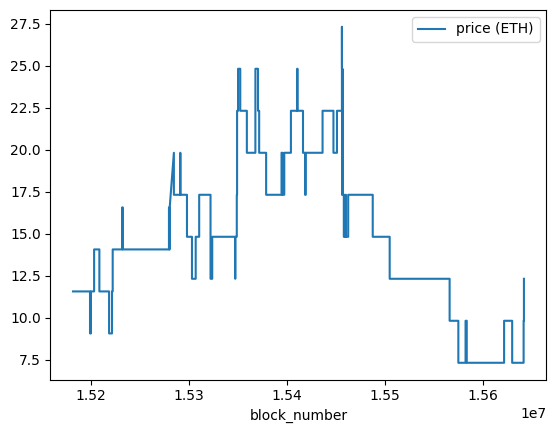

In [34]:
# plot historical prices
ax = qp.plot(x='block_number', y='newSpotPrice', label='price (ETH)')
ax.get_figure().savefig(f'notebook/assets/{pool_addr}/prices.png')

In [35]:
# determine NFT count volumes over time through query swaps cross ref'd with query_transfers_for_swaps
def get_nft_count(x: pd.Series, buy: bool) -> int:
    """
    Takes in row from query_swaps and returns nft count (buy, sell) from viewpoint of pool.
    So SwapNFTInPair is a buy for the pool and SwapNFTOutPair is a sell.
    """
    if (x['event_name'] == 'SwapNFTInPair' and not buy) or (x['event_name'] == 'SwapNFTOutPair' and buy):
        return 0
    
    tx_hash = x['transaction_hash']
    count = len(query_transfers_for_swaps[query_transfers_for_swaps['transaction_hash'] == tx_hash])
    return count

query_swaps['count_buy'] = query_swaps.apply(lambda x: get_nft_count(x, True), axis=1)
query_swaps['count_sell'] = query_swaps.apply(lambda x: get_nft_count(x, False), axis=1)

In [36]:
# get cumulative NFT counts
query_swaps['cum_count_buy'] = query_swaps['count_buy'].cumsum()
query_swaps['cum_count_sell'] = query_swaps['count_sell'].cumsum()

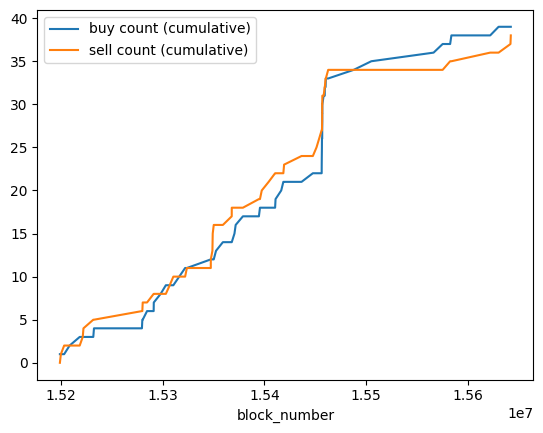

In [37]:
# plot historical cumulative volumes (in # NFTs)
# NOTE: these are the "count" fields in pool-analysis.js
ax = query_swaps.plot(x='block_number', y=['cum_count_buy', 'cum_count_sell'], label=['buy count (cumulative)', 'sell count (cumulative)'])
ax.get_figure().savefig(f'notebook/assets/{pool_addr}/cum_counts.png')

In [38]:
# now get the buy/sell cumulative volumes: volume = count * priceAtCount = priceAtCount, since each NFT transfer is 1 NFT count
# NOTE: swap volume is e.g. buyPrice + (buyPrice + 1 * delta) + ... + (buyPrice + (n-1) * delta);
# NOTE: for n NFTs swapped, where buyPrice is the *initial* spot price + delta prior to first swap happening
# SEE: https://github.com/sudoswap/lssvm/blob/main/src/bonding-curves/LinearCurve.sol#L76

In [39]:
# build up volume df
qv = qp.copy()
qv_not_initial = qv[(qv['is_initial'] == False) & (~qv['transaction_hash'].isnull())]
qv_not_initial = qv_not_initial.drop(columns=['log_index'])
qv_not_initial = qv_not_initial.rename(columns={'newSpotPrice': 'volume'})

In [40]:
# group volume by tx hash
qv = qv_not_initial.groupby(['transaction_hash']).aggregate({'block_number': 'first', 'transaction_hash': 'first', 'is_buy': 'first', 'volume': 'sum'}).sort_values(by=['block_number'])

In [41]:
qv

,block_number,transaction_hash,is_buy,volume
transaction_hash,,,,
0x195069bfc2a5e1ee78ee3cd8114fdfce8c0d482036d33938d54eb19a4b8702ed,15198846,0x195069bfc2a5e1ee78ee3cd8114fdfce8c0d482036d3...,True,9.077670
0xe6d9db380c0b7b3d9923ac18e1a920c64a60ef0e2f2ecadc5d2963f8db1aad75,15199800,0xe6d9db380c0b7b3d9923ac18e1a920c64a60ef0e2f2e...,False,11.577670
0x85212d1b00c2c505bda6b7a56d2b1f2a893646a0d55b1da2b6ecacad6cb68430,15203036,0x85212d1b00c2c505bda6b7a56d2b1f2a893646a0d55b...,False,14.077670
0x414ea41198833a399a68c9b66456047bc6dd349330d74790a25644a707d9d49d,15208415,0x414ea41198833a399a68c9b66456047bc6dd349330d7...,True,11.577670
0x28758b8d0ad21047a93b75089e210e0ca85f652842ef2cf4beabd9ad35aa6c7c,15218330,0x28758b8d0ad21047a93b75089e210e0ca85f652842ef...,True,9.077670
...,...,...,...,...
0x0f0c92c52a66419cf127e6d95465200306c53ba0f61435d731bc5e28ad68f85e,15583837,0x0f0c92c52a66419cf127e6d95465200306c53ba0f614...,True,7.330097
0x3343670d15a90410dd5f689d9e6349e2a4343b7472e0a8aa7b7ab38d4567b4c0,15622000,0x3343670d15a90410dd5f689d9e6349e2a4343b7472e0...,False,9.830097
0xb11f71335fc38495ae8e9a3dac52bf8cf452f7b02c746b570bddc15ddb4c1dbf,15630253,0xb11f71335fc38495ae8e9a3dac52bf8cf452f7b02c74...,True,7.330097


In [42]:
# determine NFT volumes (in ETH) over time through qv
def get_nft_volume(x: pd.Series, buy: bool) -> float:
    """
    Takes in row from query_swaps and returns nft volume (buy, sell) from viewpoint of pool.
    So SwapNFTInPair is a buy for the pool and SwapNFTOutPair is a sell.
    """
    if (x['event_name'] == 'SwapNFTInPair' and not buy) or (x['event_name'] == 'SwapNFTOutPair' and buy):
        return 0
    
    tx_hash = x['transaction_hash']
    y = qv[qv['transaction_hash'] == tx_hash].iloc[0]
    volume = y['volume'] if y['is_buy'] == buy else 0
    return volume

query_swaps['volume_buy'] = query_swaps.apply(lambda x: get_nft_volume(x, True), axis=1)
query_swaps['volume_sell'] = query_swaps.apply(lambda x: get_nft_volume(x, False), axis=1)

In [43]:
# get cumulative NFT volumes
query_swaps['cum_volume_buy'] = query_swaps['volume_buy'].cumsum()
query_swaps['cum_volume_sell'] = query_swaps['volume_sell'].cumsum()

In [44]:
query_swaps

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,count_buy,count_sell,cum_count_buy,cum_count_sell,volume_buy,volume_sell,cum_volume_buy,cum_volume_sell
0,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x195069bfc2a5e1ee78ee3cd8114fdfce8c0d482036d3...,15198846,0xd3b29ce639c43280c2a194b638e07a5e1541824210aa...,57,37,1,0,1,0,9.077670,0.000000,9.077670,0.000000
0,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0xe6d9db380c0b7b3d9923ac18e1a920c64a60ef0e2f2e...,15199800,0x420f1997f04b486a8ed114b32337abb0f8722e82ef1f...,82,82,0,1,1,1,0.000000,11.577670,9.077670,11.577670
1,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x85212d1b00c2c505bda6b7a56d2b1f2a893646a0d55b...,15203036,0x0e89e72ff162aa1b1ec18cdad70825885d7c0884f425...,236,138,0,1,1,2,0.000000,14.077670,9.077670,25.655340
1,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x414ea41198833a399a68c9b66456047bc6dd349330d7...,15208415,0x36dce9b484abf8db83699dabf5d63cbca4b9f68cc7e2...,123,56,1,0,2,2,11.577670,0.000000,20.655340,25.655340
2,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x28758b8d0ad21047a93b75089e210e0ca85f652842ef...,15218330,0x10112e7b56853191c7e46d36f0cca7431be567982f5c...,76,59,1,0,3,2,9.077670,0.000000,29.733010,25.655340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x0f0c92c52a66419cf127e6d95465200306c53ba0f614...,15583837,0xac80c3a0f4b64fbcb0512cf4bcbfc67f77cb37a6bd36...,85,37,1,0,38,35,7.330097,0.000000,614.781553,666.286408
32,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x3343670d15a90410dd5f689d9e6349e2a4343b7472e0...,15622000,0x76e15f58bc7e39a5e164277fa0b2bc2c6648f510adf7...,74,47,0,1,38,36,0.000000,9.830097,614.781553,676.116505
37,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0xb11f71335fc38495ae8e9a3dac52bf8cf452f7b02c74...,15630253,0x9f61426c708fcd4622f26fd23b607c65a2cf08d3c4a2...,20,26,1,0,39,36,7.330097,0.000000,622.111650,676.116505
33,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0xa1759dc5b910d93a3464b9814e8010bddd25dafe66d7...,15641940,0xf85ed36d9edc63b7dc156d4a33256e254f8e4b02498a...,159,100,0,1,39,37,0.000000,9.830097,622.111650,685.946602


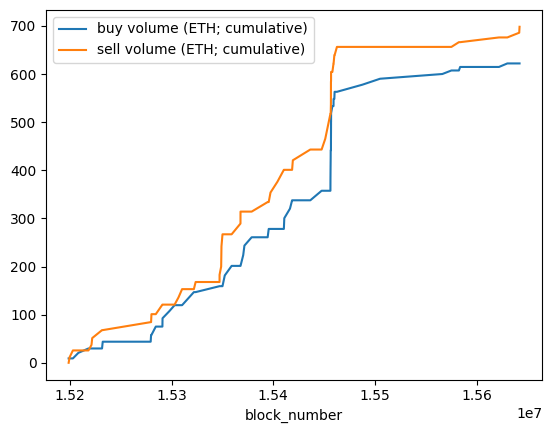

In [45]:
# plot historical cumulative volumes (in ETH)
# NOTE: these are the "amount" fields in pool-analysis.js
ax = query_swaps.plot(x='block_number', y=['cum_volume_buy', 'cum_volume_sell'], label=['buy volume (ETH; cumulative)', 'sell volume (ETH; cumulative)'])
ax.get_figure().savefig(f'notebook/assets/{pool_addr}/cum_volumes.png')

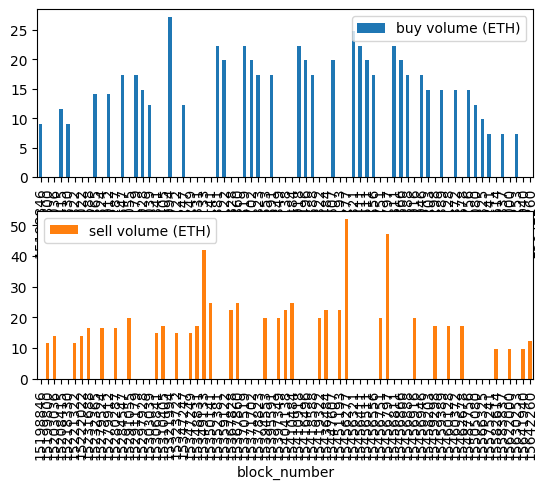

In [46]:
# plot volumes and counts (not cumulative)
fig, ax = plt.subplots(2, 1)
query_swaps.plot(x='block_number', y=['volume_buy'], ax=ax[0], kind='bar', color='C0', label=['buy volume (ETH)'])
query_swaps.plot(x='block_number', y=['volume_sell'], ax=ax[1], kind='bar', color='C1', label=['sell volume (ETH)'])
fig.savefig(f'notebook/assets/{pool_addr}/volumes.png')

In [47]:
# calculate the average buy and sell prices of the pool over time (cum_volume / cum_count)
query_swaps['avg_buy_price'] = query_swaps['cum_volume_buy'] / query_swaps['cum_count_buy']
query_swaps['avg_sell_price'] = query_swaps['cum_volume_sell'] / query_swaps['cum_count_sell']

In [48]:
query_swaps

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,count_buy,count_sell,cum_count_buy,cum_count_sell,volume_buy,volume_sell,cum_volume_buy,cum_volume_sell,avg_buy_price,avg_sell_price
0,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x195069bfc2a5e1ee78ee3cd8114fdfce8c0d482036d3...,15198846,0xd3b29ce639c43280c2a194b638e07a5e1541824210aa...,57,37,1,0,1,0,9.077670,0.000000,9.077670,0.000000,9.077670,NaN
0,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0xe6d9db380c0b7b3d9923ac18e1a920c64a60ef0e2f2e...,15199800,0x420f1997f04b486a8ed114b32337abb0f8722e82ef1f...,82,82,0,1,1,1,0.000000,11.577670,9.077670,11.577670,9.077670,11.577670
1,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x85212d1b00c2c505bda6b7a56d2b1f2a893646a0d55b...,15203036,0x0e89e72ff162aa1b1ec18cdad70825885d7c0884f425...,236,138,0,1,1,2,0.000000,14.077670,9.077670,25.655340,9.077670,12.827670
1,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x414ea41198833a399a68c9b66456047bc6dd349330d7...,15208415,0x36dce9b484abf8db83699dabf5d63cbca4b9f68cc7e2...,123,56,1,0,2,2,11.577670,0.000000,20.655340,25.655340,10.327670,12.827670
2,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x28758b8d0ad21047a93b75089e210e0ca85f652842ef...,15218330,0x10112e7b56853191c7e46d36f0cca7431be567982f5c...,76,59,1,0,3,2,9.077670,0.000000,29.733010,25.655340,9.911003,12.827670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x0f0c92c52a66419cf127e6d95465200306c53ba0f614...,15583837,0xac80c3a0f4b64fbcb0512cf4bcbfc67f77cb37a6bd36...,85,37,1,0,38,35,7.330097,0.000000,614.781553,666.286408,16.178462,19.036755
32,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x3343670d15a90410dd5f689d9e6349e2a4343b7472e0...,15622000,0x76e15f58bc7e39a5e164277fa0b2bc2c6648f510adf7...,74,47,0,1,38,36,0.000000,9.830097,614.781553,676.116505,16.178462,18.781014
37,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0xb11f71335fc38495ae8e9a3dac52bf8cf452f7b02c74...,15630253,0x9f61426c708fcd4622f26fd23b607c65a2cf08d3c4a2...,20,26,1,0,39,36,7.330097,0.000000,622.111650,676.116505,15.951581,18.781014
33,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0xa1759dc5b910d93a3464b9814e8010bddd25dafe66d7...,15641940,0xf85ed36d9edc63b7dc156d4a33256e254f8e4b02498a...,159,100,0,1,39,37,0.000000,9.830097,622.111650,685.946602,15.951581,18.539097


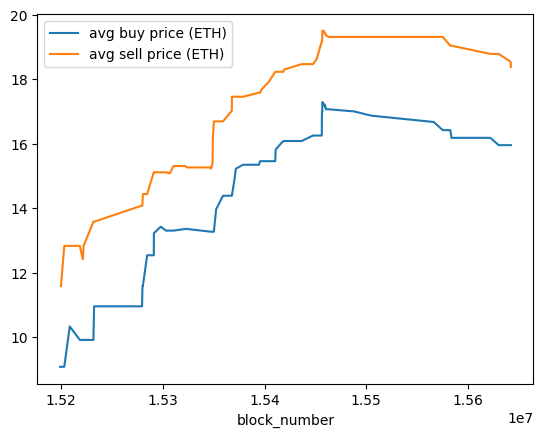

In [49]:
# plot historical average buy/sell prices (in ETH)
ax = query_swaps.plot(x='block_number', y=['avg_buy_price', 'avg_sell_price'], label=['avg buy price (ETH)', 'avg sell price (ETH)'])
ax.get_figure().savefig(f'notebook/assets/{pool_addr}/avg_prices.png')

In [50]:
# calc trading fees over time. Easiest to charge on volume to determine
query_swaps['volume'] = query_swaps['volume_buy'] + query_swaps['volume_sell']

In [51]:
def get_fees(x: pd.Series) -> float:
    """
    Takes in row from query_swaps and returns fees from swap volume.
    """
    # get the current fee rate
    qf = query_fee_updates[query_fee_updates['block_number'] <= x['block_number']]
    fee = qf.iloc[-1]['newFee'] if not qf.empty else fee_initial
    fee /= 1e18  # normalize wrt 18 decimals
    
    fees = x['volume'] * fee
    return fees

query_swaps['fees'] = query_swaps.apply(get_fees, axis=1)

In [52]:
# get the cumulative fees
query_swaps['cum_fees'] = query_swaps['fees'].cumsum()

In [53]:
query_swaps

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,count_buy,count_sell,...,cum_count_sell,volume_buy,volume_sell,cum_volume_buy,cum_volume_sell,avg_buy_price,avg_sell_price,volume,fees,cum_fees
0,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x195069bfc2a5e1ee78ee3cd8114fdfce8c0d482036d3...,15198846,0xd3b29ce639c43280c2a194b638e07a5e1541824210aa...,57,37,1,0,...,0,9.077670,0.000000,9.077670,0.000000,9.077670,NaN,9.077670,0.226942,0.226942
0,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0xe6d9db380c0b7b3d9923ac18e1a920c64a60ef0e2f2e...,15199800,0x420f1997f04b486a8ed114b32337abb0f8722e82ef1f...,82,82,0,1,...,1,0.000000,11.577670,9.077670,11.577670,9.077670,11.577670,11.577670,0.289442,0.516383
1,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x85212d1b00c2c505bda6b7a56d2b1f2a893646a0d55b...,15203036,0x0e89e72ff162aa1b1ec18cdad70825885d7c0884f425...,236,138,0,1,...,2,0.000000,14.077670,9.077670,25.655340,9.077670,12.827670,14.077670,0.351942,0.868325
1,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x414ea41198833a399a68c9b66456047bc6dd349330d7...,15208415,0x36dce9b484abf8db83699dabf5d63cbca4b9f68cc7e2...,123,56,1,0,...,2,11.577670,0.000000,20.655340,25.655340,10.327670,12.827670,11.577670,0.289442,1.157767
2,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x28758b8d0ad21047a93b75089e210e0ca85f652842ef...,15218330,0x10112e7b56853191c7e46d36f0cca7431be567982f5c...,76,59,1,0,...,2,9.077670,0.000000,29.733010,25.655340,9.911003,12.827670,9.077670,0.226942,1.384709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x0f0c92c52a66419cf127e6d95465200306c53ba0f614...,15583837,0xac80c3a0f4b64fbcb0512cf4bcbfc67f77cb37a6bd36...,85,37,1,0,...,35,7.330097,0.000000,614.781553,666.286408,16.178462,19.036755,7.330097,0.183252,32.026699
32,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x3343670d15a90410dd5f689d9e6349e2a4343b7472e0...,15622000,0x76e15f58bc7e39a5e164277fa0b2bc2c6648f510adf7...,74,47,0,1,...,36,0.000000,9.830097,614.781553,676.116505,16.178462,18.781014,9.830097,0.245752,32.272451
37,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0xb11f71335fc38495ae8e9a3dac52bf8cf452f7b02c74...,15630253,0x9f61426c708fcd4622f26fd23b607c65a2cf08d3c4a2...,20,26,1,0,...,36,7.330097,0.000000,622.111650,676.116505,15.951581,18.781014,7.330097,0.183252,32.455704
33,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0xa1759dc5b910d93a3464b9814e8010bddd25dafe66d7...,15641940,0xf85ed36d9edc63b7dc156d4a33256e254f8e4b02498a...,159,100,0,1,...,37,0.000000,9.830097,622.111650,685.946602,15.951581,18.539097,9.830097,0.245752,32.701456


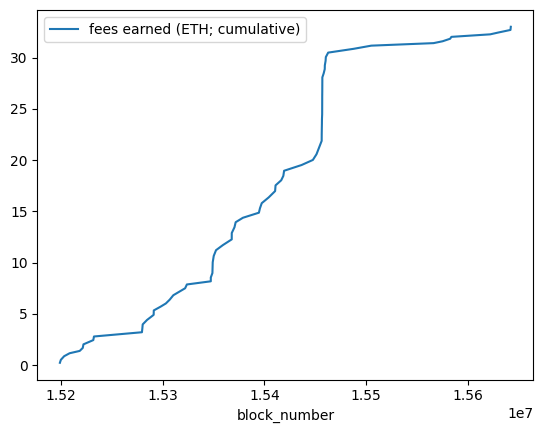

In [54]:
# looks consistent with delta between deploy tx w NFT + ETH sent in and current NFT + ETH amounts
ax = query_swaps.plot(x='block_number', y='cum_fees', label='fees earned (ETH; cumulative)')
ax.get_figure().savefig(f'notebook/assets/{pool_addr}/cum_fees.png')

In [55]:
# calc scaling factor and spread earned
query_swaps['scaling_factor'] = np.minimum(query_swaps['cum_count_buy'], query_swaps['cum_count_sell'])
query_swaps['spread'] = query_swaps['scaling_factor'] * (query_swaps['avg_sell_price'] - query_swaps['avg_buy_price'])

In [56]:
query_swaps

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,count_buy,count_sell,...,volume_sell,cum_volume_buy,cum_volume_sell,avg_buy_price,avg_sell_price,volume,fees,cum_fees,scaling_factor,spread
0,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x195069bfc2a5e1ee78ee3cd8114fdfce8c0d482036d3...,15198846,0xd3b29ce639c43280c2a194b638e07a5e1541824210aa...,57,37,1,0,...,0.000000,9.077670,0.000000,9.077670,NaN,9.077670,0.226942,0.226942,0,NaN
0,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0xe6d9db380c0b7b3d9923ac18e1a920c64a60ef0e2f2e...,15199800,0x420f1997f04b486a8ed114b32337abb0f8722e82ef1f...,82,82,0,1,...,11.577670,9.077670,11.577670,9.077670,11.577670,11.577670,0.289442,0.516383,1,2.500000
1,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x85212d1b00c2c505bda6b7a56d2b1f2a893646a0d55b...,15203036,0x0e89e72ff162aa1b1ec18cdad70825885d7c0884f425...,236,138,0,1,...,14.077670,9.077670,25.655340,9.077670,12.827670,14.077670,0.351942,0.868325,1,3.750000
1,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x414ea41198833a399a68c9b66456047bc6dd349330d7...,15208415,0x36dce9b484abf8db83699dabf5d63cbca4b9f68cc7e2...,123,56,1,0,...,0.000000,20.655340,25.655340,10.327670,12.827670,11.577670,0.289442,1.157767,2,5.000000
2,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x28758b8d0ad21047a93b75089e210e0ca85f652842ef...,15218330,0x10112e7b56853191c7e46d36f0cca7431be567982f5c...,76,59,1,0,...,0.000000,29.733010,25.655340,9.911003,12.827670,9.077670,0.226942,1.384709,2,5.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x0f0c92c52a66419cf127e6d95465200306c53ba0f614...,15583837,0xac80c3a0f4b64fbcb0512cf4bcbfc67f77cb37a6bd36...,85,37,1,0,...,0.000000,614.781553,666.286408,16.178462,19.036755,7.330097,0.183252,32.026699,35,100.040240
32,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0x3343670d15a90410dd5f689d9e6349e2a4343b7472e0...,15622000,0x76e15f58bc7e39a5e164277fa0b2bc2c6648f510adf7...,74,47,0,1,...,9.830097,614.781553,676.116505,16.178462,18.781014,9.830097,0.245752,32.272451,36,93.691875
37,SwapNFTInPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0xb11f71335fc38495ae8e9a3dac52bf8cf452f7b02c74...,15630253,0x9f61426c708fcd4622f26fd23b607c65a2cf08d3c4a2...,20,26,1,0,...,0.000000,622.111650,676.116505,15.951581,18.781014,7.330097,0.183252,32.455704,36,101.859597
33,SwapNFTOutPair,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{},0xa1759dc5b910d93a3464b9814e8010bddd25dafe66d7...,15641940,0xf85ed36d9edc63b7dc156d4a33256e254f8e4b02498a...,159,100,0,1,...,9.830097,622.111650,685.946602,15.951581,18.539097,9.830097,0.245752,32.701456,37,95.738113


In [57]:
# TODO: fix spread since seems way off
# ax = query_swaps.plot(x='block_number', y='spread', label='total spread earned (ETH)')
# ax.get_figure().savefig('notebook/assets/total_spreads.png')

In [58]:
# TODO: fancy plots with mplfinance